In [1]:
import os
import cv2
import pickle 
import numpy as np
import tensorflow as tf
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense , Flatten , BatchNormalization , Dropout , Conv2D , MaxPooling2D 

2024-02-04 11:28:14.240842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 11:28:16.928007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices('GPU')

2024-02-04 11:28:20.970634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 11:28:21.448457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 11:28:21.449112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# main_directory/
#     class_1/
#         img_1.jpg
#         img_2.jpg
#     class_2/
#         img_1.jpg
#         img_2.jpg


train = tf.keras.utils.image_dataset_from_directory(
    directory='Data/train',
    validation_split=0.2,
    subset="training",
    batch_size=16,
    image_size=(420,420),
    seed=128
)

test = tf.keras.utils.image_dataset_from_directory(
    directory='Data/test',
    validation_split=0.2,
    subset="training",
    batch_size=16,
    image_size=(420,420),
    seed=128
)

Found 66049 files belonging to 7 classes.
Using 52840 files for training.


2024-02-04 11:29:51.121090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 11:29:51.121388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 11:29:51.121619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 11:29:51.324314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 11:29:51.324679: I tensorflow/compile

Found 1750 files belonging to 7 classes.
Using 1400 files for training.


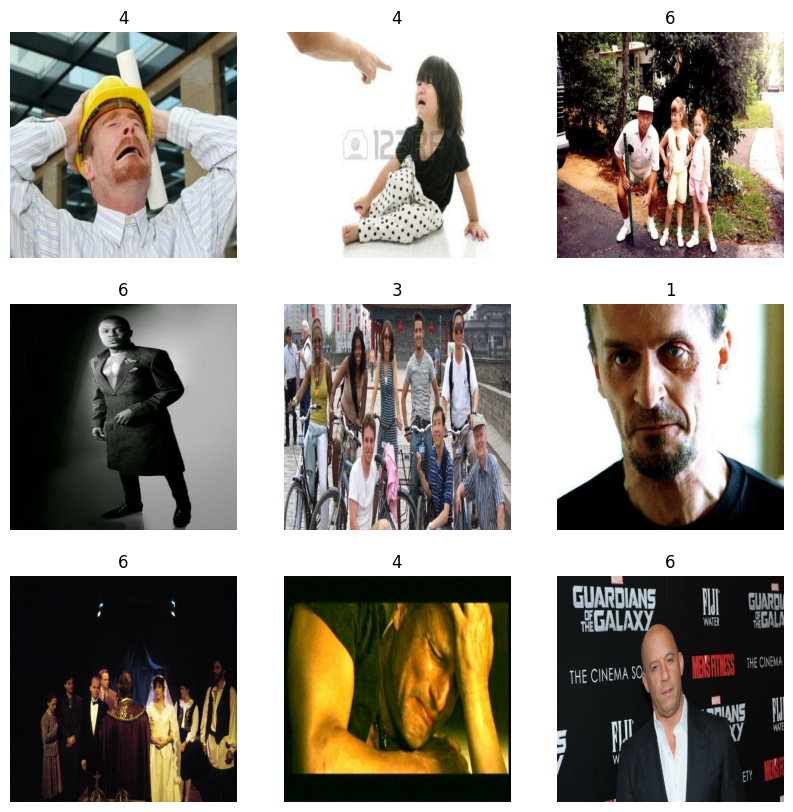

In [4]:
class_names = train.class_names
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
def Normalize(image , label):
    image = tf.cast(image/255 , tf.float32)
    return image , label 

train_ds = train.map(Normalize)    
test_ds = test.map(Normalize)

In [6]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(420,420,3)
)

In [112]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [8]:
model = Sequential()

model.add(conv_base)

model.add(Flatten())

model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(94,activation='relu' , kernel_regularizer=regularizers.l1(0.06)))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu' ))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu' ))
model.add(BatchNormalization())
model.add(Dense(32,activation='relu' ))

model.add(Dense(7 , activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 13, 13, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 86528)             0         
                                                                 
 dense (Dense)               (None, 128)               11075712  
                                                                 
 dense_1 (Dense)             (None, 94)                12126     
                                                                 
 dense_2 (Dense)             (None, 64)                6080      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 7)                 2

In [10]:
model.compile(optimizer='Adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

In [11]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=30, validation_data= test_ds )


Epoch 1/20


2024-02-04 11:29:58.766292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-02-04 11:29:59.596570: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-04 11:29:59.606492: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-02-04 11:29:59.606700: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-02-04 11:29:59.606904: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-02-04 

3303/3303 [==============================] - 482s 144ms/step - loss: 2.9664 - accuracy: 0.3828 - val_loss: 2.4243 - val_accuracy: 0.2093
Epoch 2/20
3303/3303 [==============================] - 479s 145ms/step - loss: 1.5974 - accuracy: 0.4073 - val_loss: 2.4062 - val_accuracy: 0.2286
Epoch 3/20
3303/3303 [==============================] - 482s 146ms/step - loss: 1.5287 - accuracy: 0.4731 - val_loss: 2.2080 - val_accuracy: 0.2771
Epoch 4/20
3303/3303 [==============================] - 479s 145ms/step - loss: 1.4776 - accuracy: 0.5036 - val_loss: 2.1818 - val_accuracy: 0.2986
Epoch 5/20
3303/3303 [==============================] - 478s 145ms/step - loss: 1.4472 - accuracy: 0.5187 - val_loss: 2.2536 - val_accuracy: 0.2921
Epoch 6/20
3303/3303 [==============================] - 478s 144ms/step - loss: 1.4092 - accuracy: 0.5337 - val_loss: 2.2491 - val_accuracy: 0.3029
Epoch 7/20
3303/3303 [==============================] - 479s 145ms/step - loss: 1.3982 - accuracy: 0.5511 - val_loss: 2.112

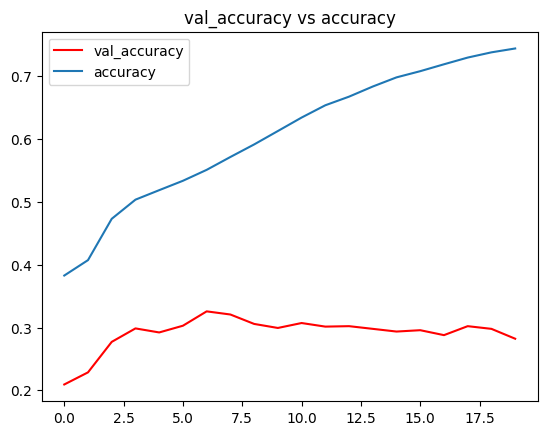

In [13]:
plt.plot(history.history['val_accuracy'] , 'red' , label='val_accuracy' )
plt.plot(history.history['accuracy'] , label='accuracy')
plt.title('val_accuracy vs accuracy')
plt.legend()

In [14]:
pickle.dump(model , open('mode_vgg16.pkl' , 'wb'))

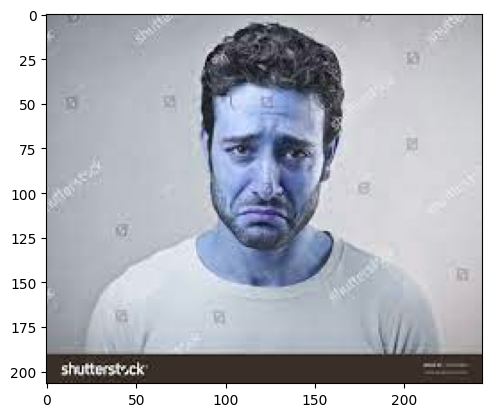

In [108]:
Image = cv2.imread('sad.jpg')
plt.imshow(Image)

In [109]:
Image = cv2.resize(Image,(420,420))
output = model.predict(Image.reshape((1,420,420,3)))
output

1/1 [==============================] - 0s 18ms/step


array([[0.00962045, 0.07116923, 0.00112034, 0.01707542, 0.07194526,
        0.01325562, 0.8158137 ]], dtype=float32)

In [110]:
output.max()

0.8158137

In [111]:
decode = {
    0 : "angry",
    1 : "disgust",
    2 : "fear",
    3 : "happy",
    4 : "sad",
    5 : "surprise",
    6 : "neutral",
}
for key , value in decode.items():
    if np.where(output==output.max())[1] == key:
        print(value)

neutral


In [18]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 1.9 GB  |     Proc size: 3.3 GB
GPU RAM Free: 1775MB | Used: 6244MB | Util  76% | Total     8192MB
